In [1]:
import itertools

from mqdq import hexameter_corpus
from mqdq import utils
from mqdq import line_analyzer as la
from mqdq import mahalanobis as maha

import numpy as np
import pandas as pd
import scipy as sp

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate

from tqdm import tqdm as tqdm_base
import sys

In [2]:
# sklearn can be noisy.

import warnings
warnings.filterwarnings('ignore')

In [3]:
# this is hax to stop tqdm from going crazy sometimes
# when a Jupyter notebook is interrupted and an old
# instance goes stale.
# orig: https://github.com/tqdm/tqdm/issues/375#issuecomment-522182387
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

In [4]:
# Load R magic for Jupyter

%load_ext rpy2.ipython

In [5]:
%%R

# Setup R stuff. Not sure if I use all of this, it's my standard bundle.

pacman::p_load(
    tidyverse,forcats,
    readxl,microbenchmark,ggsci,
    gapminder,broom,purrrlyr,knitr,
    DT,htmlTable, grid, ggpubr
)

In [6]:
# The MQDQParser package has this corpus pre-cleaned and
# built in.

corp = hexameter_corpus.geezit_corpus()

100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


In [7]:
corp.head()

LN  Book    Work  Author                                                XML
0   1     1  Aeneid  Vergil  [\n, [Arma], \n, [uirumque], \n, [cano,], \n, ...
1   2     1  Aeneid  Vergil  [\n, [Italiam], \n, [fato], \n, [profugus], \n...
2   3     1  Aeneid  Vergil  [\n, [Litora,], \n, [multum], \n, [ille], \n, ...
3   4     1  Aeneid  Vergil  [\n, [Vi], \n, [superum,], \n, [saeuae], \n, [...
4   5     1  Aeneid  Vergil  [\n, [Multa], \n, [quoque], \n, [et], \n, [bel...

In [8]:
CLASSIFIERS = [
    ('GaussianNB', lambda: GaussianNB()),
    ('Logistic', lambda: LogisticRegression(penalty='none', solver='lbfgs', multi_class='auto', max_iter=500)),
    ('ExtraTrees', lambda: ExtraTreesClassifier(n_estimators=500,min_samples_split=2)),
    ('SVM', lambda: SVC(gamma='scale', kernel='rbf', C=128))
]

In [9]:
vecs_byauth = hexameter_corpus.vectorize_prosody(corp, by='Author')
vecs_bya_na = vecs_byauth.query('Author != "PsSilius"')

# two sets, 81 line chunks, sequential and randomised.

authc81 = hexameter_corpus.rechunk(vecs_bya_na, n=81)
authc81r = hexameter_corpus.rechunk(vecs_bya_na, n=81, rand=True, seed=42)

In [10]:
# Figure 2: Classification Accuracy by Chunk Size: Randomised vs Sequential Chunks

In [11]:
def test_clf_by_chunksz(clfs, corp, sizes, rand_chunks=False, seed=None, samps=100):
    """
    Expects a vectorized corpus, one vector per line.
    
    Chunks the corpus into the sizes given, optionally randomising each
    work before chunking. Then scores each classifer in clf with $samps
    StratifiedShuffleSplit iterations, with an 80/20 train/test split.
    
    Multi-label fitting strategy is up to each classifier.
    
    Scoring is F1-weighted.
    """
    res = []
    # this makes a seeded rng, instead of seeding the ShuffleSplit
    # with the same value each time, which seems slightly cleaner.
    rng = np.random.RandomState(seed=seed)
    for (name, c) in clfs:
        print("Starting %s..." % name)
        for (idx,sz) in enumerate(tqdm(sizes, file=sys.stdout, ncols=100)):
            if sz==0:
                sz=1
            chunked = hexameter_corpus.rechunk(corp, n=sz, rand=rand_chunks, seed=seed)
            X,y = chunked[la.ALL_FEATURES], chunked.Author
            cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=rng)
            # note to self: don't run parallel jobs if you have a seeded rng >:(
            samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=1, scoring='f1_weighted')
            m = sp.mean(samp_res)
            res.append({'Classifier':name, 'Score':m, 'Size': sz})
    return pd.DataFrame(res)

In [12]:
res_clf_multi_rand = test_clf_by_chunksz(CLASSIFIERS, vecs_bya_na, range(5,151,5), rand_chunks=True, samps=100, seed=42)

Starting GaussianNB...
100%|███████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.14it/s]
Starting Logistic...
100%|███████████████████████████████████████████████████████████████| 30/30 [10:33<00:00, 21.11s/it]
Starting ExtraTrees...
100%|███████████████████████████████████████████████████████████████| 30/30 [49:35<00:00, 99.19s/it]
Starting SVM...
100%|███████████████████████████████████████████████████████████████| 30/30 [35:54<00:00, 71.80s/it]


In [13]:
res_clf_multi_seq = test_clf_by_chunksz(CLASSIFIERS, vecs_bya_na, range(5,151,5), rand_chunks=False, samps=100, seed=42)

Starting GaussianNB...
100%|███████████████████████████████████████████████████████████████| 30/30 [00:24<00:00,  1.23it/s]
Starting Logistic...
100%|███████████████████████████████████████████████████████████████| 30/30 [12:02<00:00, 24.08s/it]
Starting ExtraTrees...
100%|██████████████████████████████████████████████████████████████| 30/30 [50:29<00:00, 100.99s/it]
Starting SVM...
100%|███████████████████████████████████████████████████████████████| 30/30 [37:04<00:00, 74.14s/it]


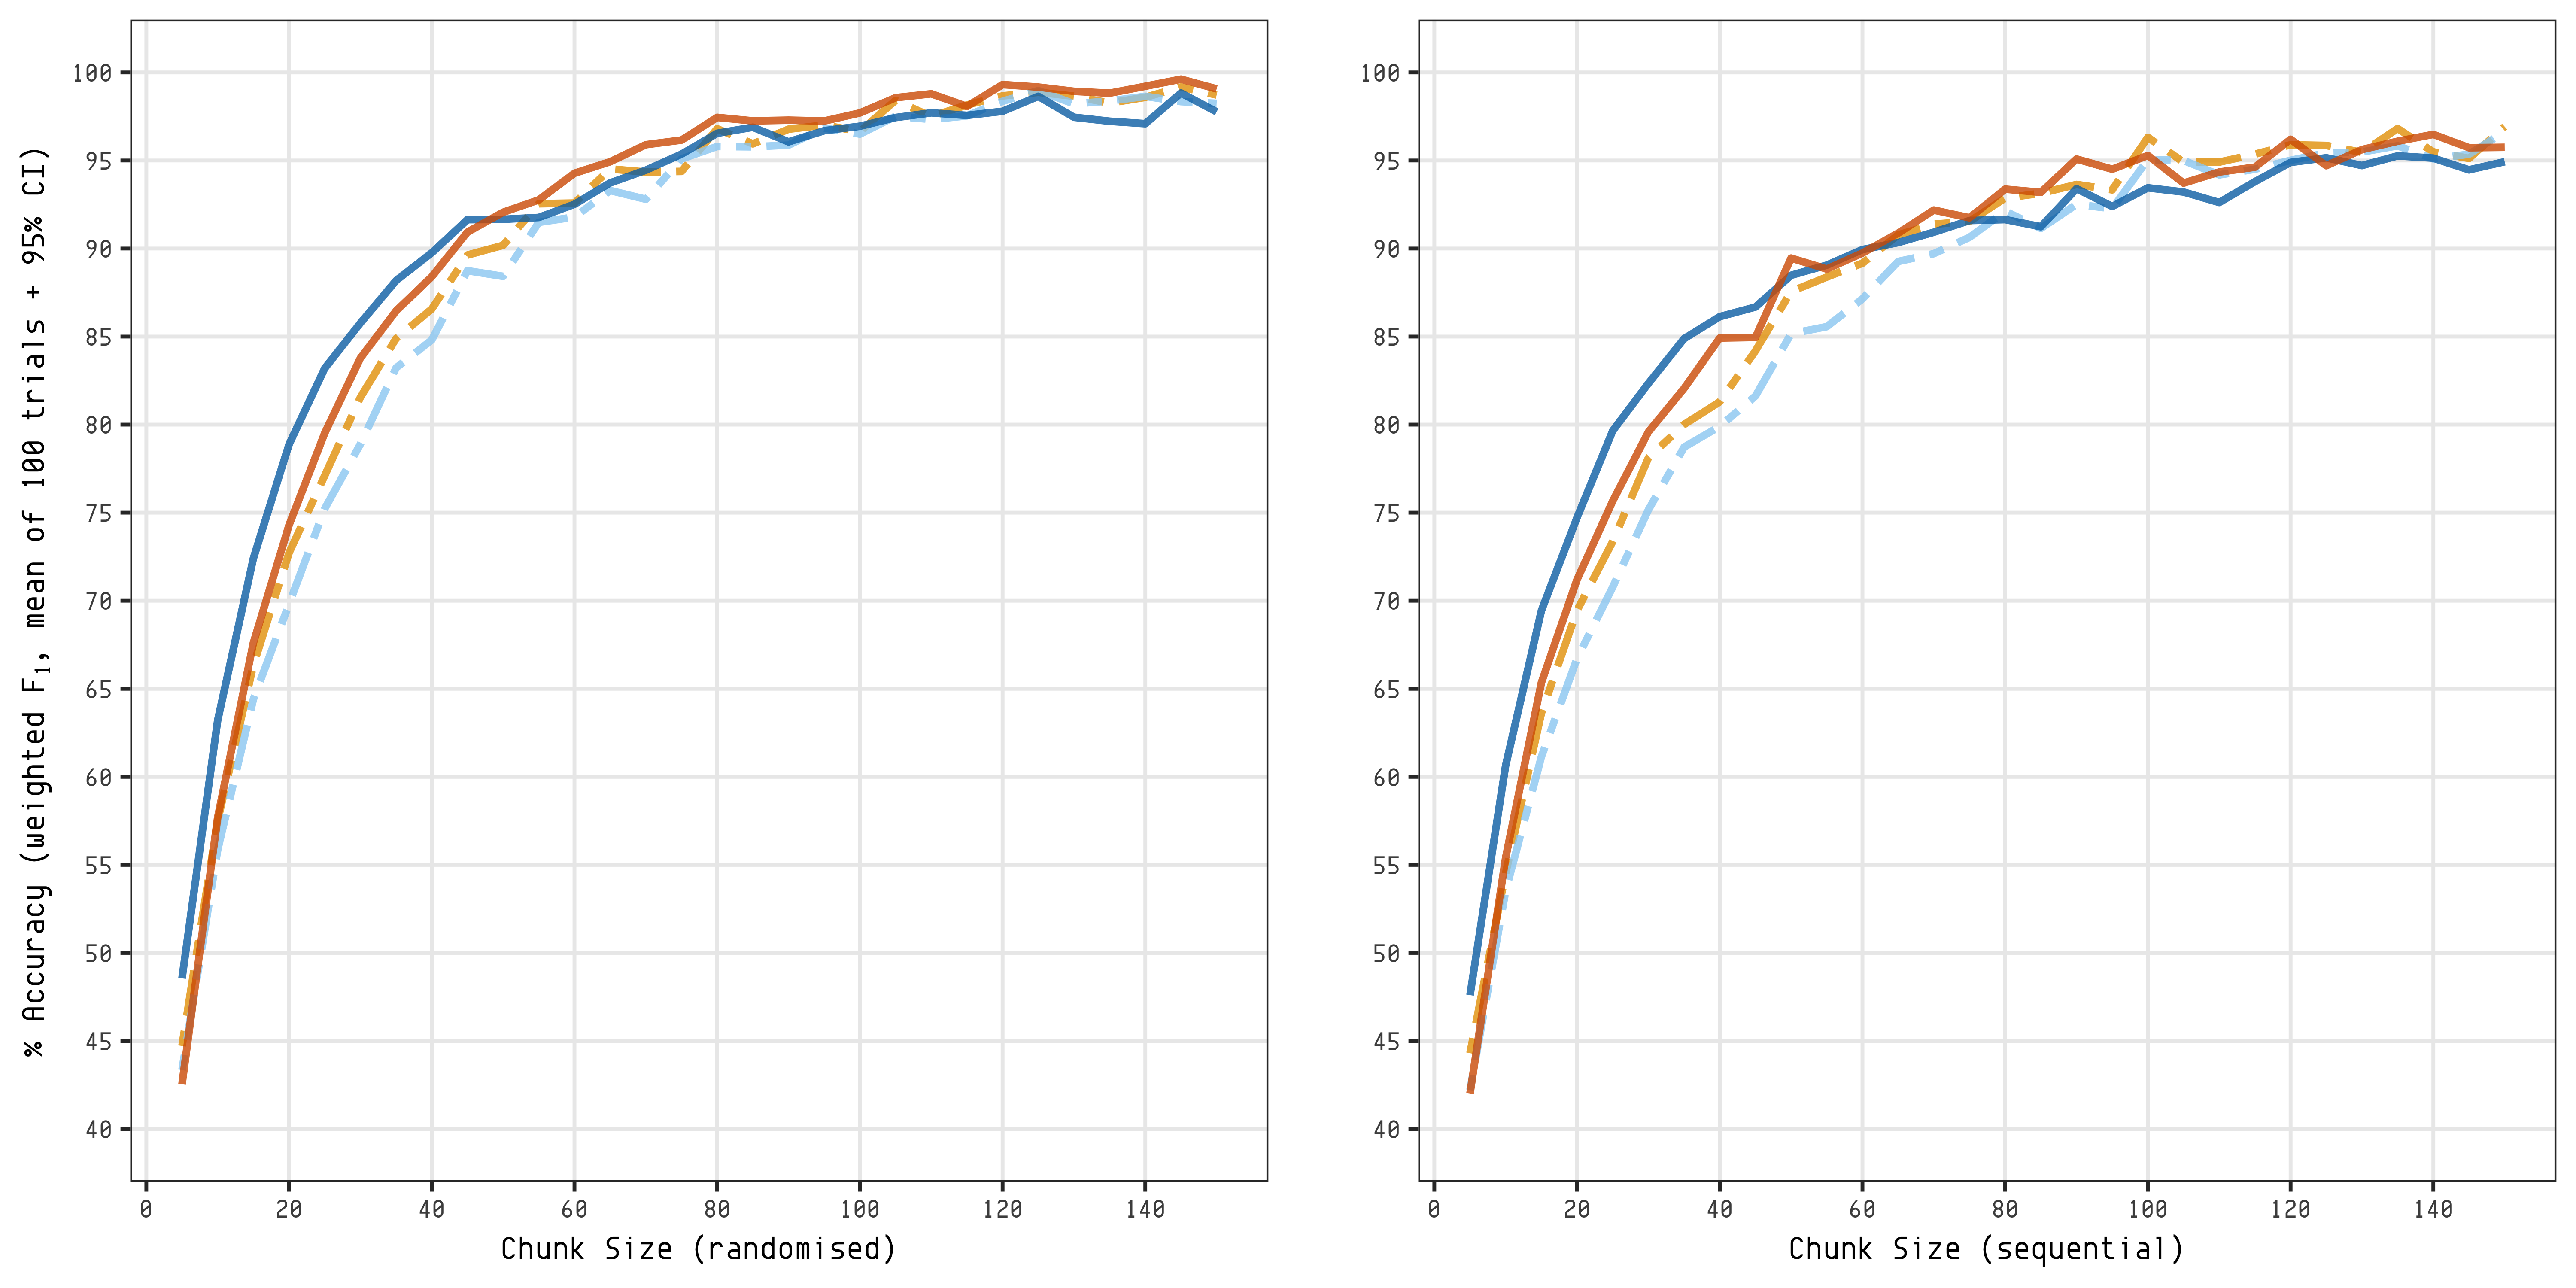

In [68]:
%%R -i res_clf_multi_rand,res_clf_multi_seq -h 5 -w 10 -u in -r 600

# this is a colorblind-friendly palette
cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

# We create two plots and bind them with ggarrange...

p1 <- ggplot(data=res_clf_multi_rand, aes(x=Size, y=Score*100, linetype=Classifier)) + 
geom_line(aes(color=Classifier), alpha=0.8, size=1) +
# I'm not sure there are any sets of _four_ colours that work well for
# all colorblind, so we have two different linetypes.
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
scale_colour_manual(values=cbbPaletteDark[c(2:5)]) +
# scale_colour_manual(values=greys) +
labs(x="Chunk Size (randomised)", y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
scale_x_continuous(breaks = seq(0,150,20)) +
# force the y limits so that the tick marks are aligned
# between the two plots
scale_y_continuous(limits=c(40,100), breaks = seq(0,100,5)) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank())

p2 <- ggplot(data=res_clf_multi_seq, aes(x=Size, y=Score*100, linetype=Classifier)) + 
geom_line(aes(color=Classifier), alpha=0.8, size=1) +
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
scale_colour_manual(values=cbbPaletteDark[c(2:5)]) +
# scale_colour_manual(values=greys) +
labs(x="Chunk Size (sequential)", y="") +
scale_x_continuous(breaks = seq(0,150,20)) +
scale_y_continuous(limits=c(40,100), breaks = seq(0,100,5)) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank())

# there's a Jupyter bug I'm avoiding here, which prints a (harmless but ugly)
# white box if the option common_legend=TRUE is used.

ggarrange(p1, p2, legend="none", align="v")


In [15]:
# Table 2: How Many Lines? Approximate number of lines required before 
# all four classifiers reach at least 90% accuracy. Pairwise comparisons,
# randomised vs sequential chunks.

In [16]:
authors = ["Silius", "Vergil", "Ovid", "Statius", "Lucan", "Juvenal"]
pairs = list(itertools.combinations(authors, 2))

def do_class(c, filtered_df):
    """
    Runs one classifier on one data frame. The way it is expected
    to be used is in the map below, but it would work without the
    df being filtered, I guess.
    """
    X,y = filtered_df[la.ALL_FEATURES], filtered_df.Author
    cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=rng)
    # not doing f1 because this is just a pairwise comparison
    samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=1)
    return sp.mean(samp_res)

# glom all the results into one array and tidy it up later
res = []

# Could be shorter, but this is fairly transparent. Run the classifiers
# for each pair at increasing chunk sizes until every classifier reports
# > 90% accuracy. Once random, once shuffled.

rng = np.random.RandomState(seed=42)
for (idx,(a,b)) in enumerate(tqdm(pairs, file=sys.stdout, ncols=80)):
        
    for chunksz in range(5,151,5):
        corp_chunk = hexameter_corpus.rechunk(vecs_byauth, chunksz, rand=True, seed=42)
        corp_chunk_filter = corp_chunk.query('Author=="%s" or Author == "%s"' % (a, b))
        scores = list(map(lambda c: do_class(c, corp_chunk_filter), [x[1] for x in CLASSIFIERS]))
        if all(x > 0.90 for x in scores):
            res.append({'Pair':'%s vs %s'%(a, b), 'Shuf':chunksz})
            break
            
rng = np.random.RandomState(seed=42)
for (idx,(a,b)) in enumerate(tqdm(pairs, file=sys.stdout, ncols=80)):
    
    for chunksz in range(5,151,5):
        corp_chunk = hexameter_corpus.rechunk(vecs_byauth, chunksz)
        corp_chunk_filter = corp_chunk.query('Author=="%s" or Author == "%s"' % (a, b))
        scores = list(map(lambda c: do_class(c, corp_chunk_filter), [x[1] for x in CLASSIFIERS]))
        if all(x > 0.90 for x in scores):
            res.append({'Pair':'%s vs %s'%(a, b), 'Unshuf':chunksz})
            break
            
how_many = pd.DataFrame(res)
# this is the "tidying up" part.
# group_by merges the duplicate row names (the "Pair" column)
how_many = how_many.groupby('Pair').first().reset_index()

100%|████████████████████████████████████████| 15/15 [2:41:35<00:00, 646.38s/it]


In [17]:
how_many.sort_values(by=['Unshuf','Shuf'], ascending=False)

Pair  Shuf  Unshuf
8     Silius vs Vergil  55.0    75.0
14   Vergil vs Statius  40.0    50.0
4    Silius vs Juvenal  40.0    40.0
11   Vergil vs Juvenal  35.0    40.0
3      Ovid vs Statius  30.0    35.0
0     Lucan vs Juvenal  25.0    25.0
9   Statius vs Juvenal  25.0    25.0
2        Ovid vs Lucan  20.0    25.0
7    Silius vs Statius  20.0    25.0
10    Statius vs Lucan  20.0    20.0
1      Ovid vs Juvenal  15.0    15.0
5      Silius vs Lucan  15.0    15.0
12     Vergil vs Lucan  15.0    15.0
13      Vergil vs Ovid  15.0    15.0
6       Silius vs Ovid  10.0    10.0

In [18]:
# Figure 3: Parsimonious Models: Selecting a Feature Subset
# (multiclass, randomised 81-line chunks)

In [19]:
def test_clf_by_feats(clfs, corp, feats, size=81, seed=None, rand_chunks=True, samps=100, confidence=0.95, by='Author'):
    """
    Expects a vectorized corpus, one vector per line.
    
    feats is a list of tuples, (set_name, feats) where feats is a list
    of features.
    
    Chunks the corpus into the size given, optionally randomising each
    work before chunking. Then scores each classifer in clfs with samps
    StratifiedShuffleSplit iterations, with an 80/20 train/test split.
    
    Multi-label fitting strategy is up to each classifier. The default
    for these ones I think is all OVR.
    
    Scoring is F1-weighted.
    """    
    res = []
    rng = np.random.RandomState(seed=seed)
    chunked = hexameter_corpus.rechunk(corp, n=size, rand=rand_chunks, seed=seed, by=by)
    for (fname, f) in feats:
        for (name, c) in clfs:
            X,y = chunked[f], chunked[by]
            cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=rng)
            samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=1, scoring='f1_weighted')
            m = sp.mean(samp_res)
            se = sp.stats.sem(samp_res)
            # student's T, 'percent point function'
            ci = se * sp.stats.t.ppf((1 + confidence) / 2, samps - 1)
            res.append({'Classifier':name, 'Features':fname, 'Score':m, 'CI': ci})
    return pd.DataFrame(res)

In [20]:
# Slightly circular, sorry, but these are the features as ordered
# by the mean in Table 3. This is not perfect. There's no reason
# to suppose that the top N features is actually the best feature
# set of size N, so we could probably do better with either a (large)
# combinatorial search or some kind of GA, but it all seems like
# overkill. This will give us an idea of the answer to our "how many
# lines?" question.

ordered_feats = [
 'ELC',
 '1SP',
 '4SP',
 '3WC',
 '3DI',
 '4SC',
 '1WC',
 '3CF',
 '2DI',
 '4CF',
 '3SC',
 '1DI',
 '2WC',
 '1CF',
 '2CF',
 '3SP',
 '1SC',
 '4DI',
 '2SC',
 '2SP',
 '4WC']
feat_list = [(x, ordered_feats[:x]) for x in range(2,22)]

In [21]:
# Test the performance of the first n features (all vs all)

vecs_bywork = hexameter_corpus.vectorize_prosody(corp, by='Work')
best_n_res = test_clf_by_feats(CLASSIFIERS, vecs_bywork, feat_list, size=81, samps=100, by='Work')

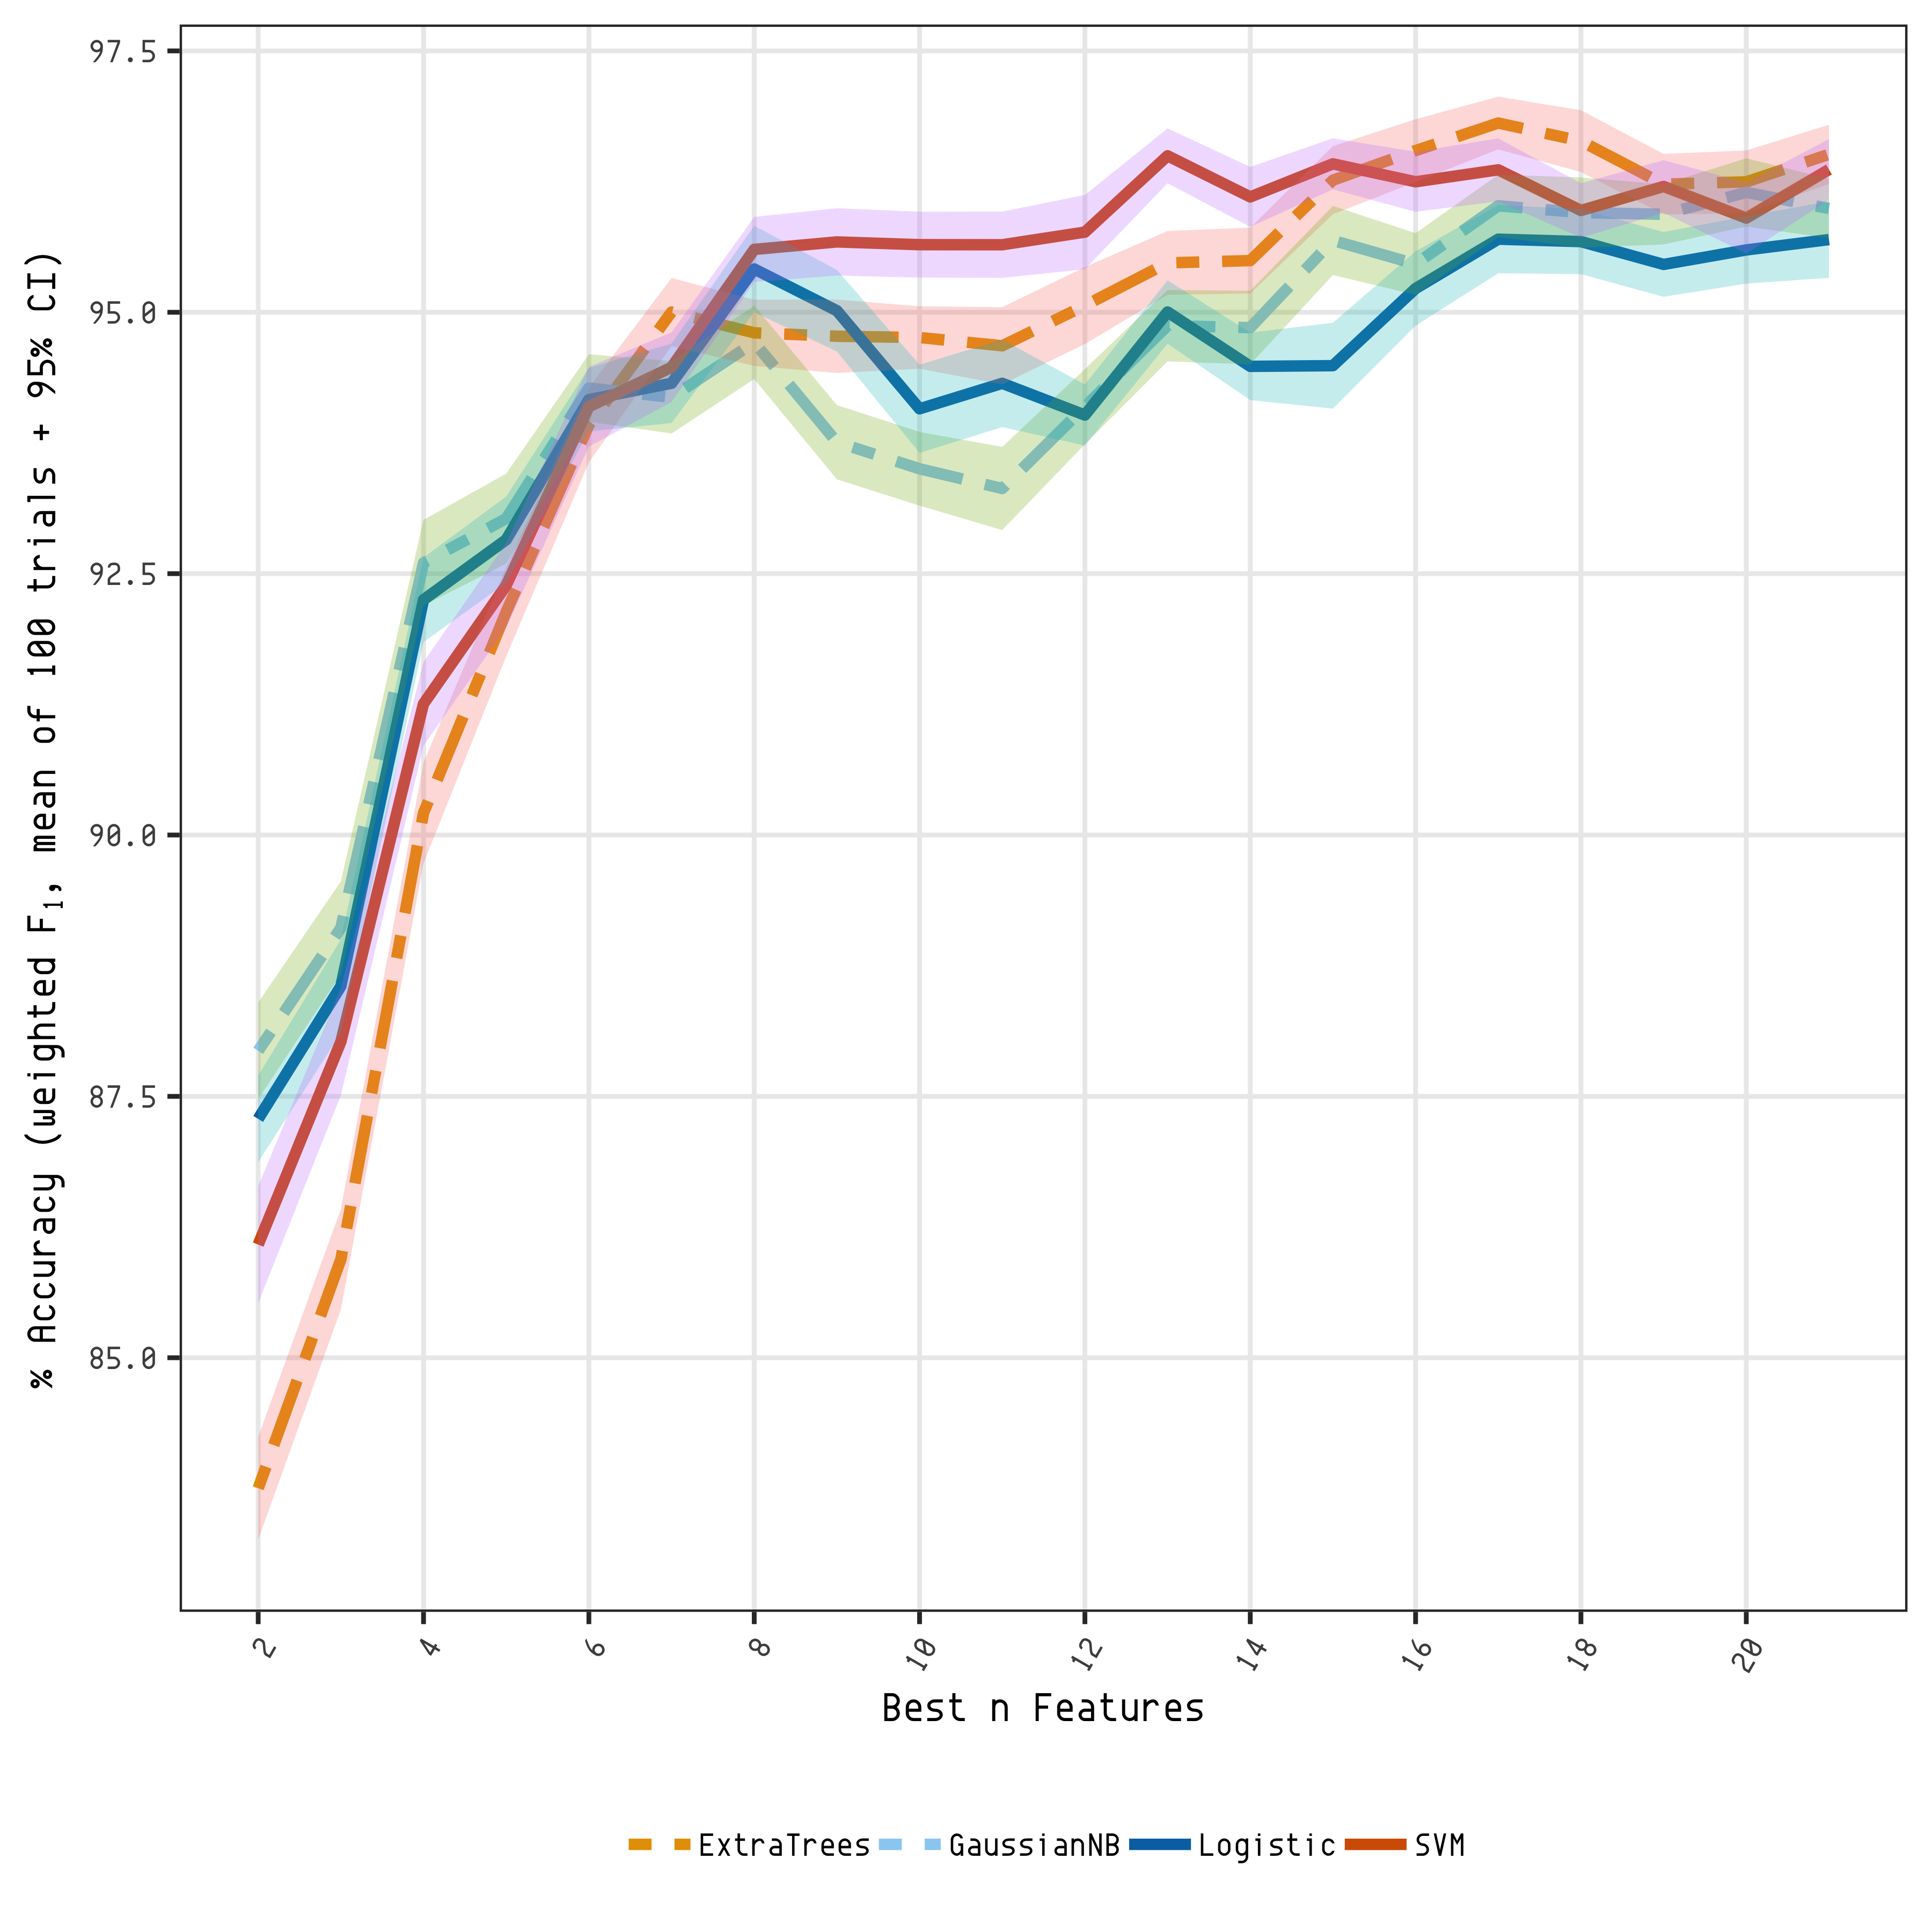

In [72]:
%%R -i best_n_res -h 6 -w 6 -u in -r 600

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

ggplot(data=best_n_res, aes(x=Features, y=Score*100, linetype=Classifier)) +
geom_line(aes(color=Classifier), size=1.2) +
#This CI band is not shown in the B&W figure, because it's not useful in monochrome
geom_ribbon(
    aes(ymin=Score*100-CI*100, ymax=Score*100+CI*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
labs(x="Best n Features",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(legend.position="bottom") +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("twodash", "twodash", "solid", "solid")) +
scale_x_continuous(breaks = seq(0,22,2)) +
scale_y_continuous(breaks = seq(85,100,2.5)) +
# scale_color_manual(values=greys)
scale_color_manual(values=cbbPaletteDark[c(2:5)])

In [23]:
# Figure 4: Classification Accuracy Confusion Matrix (classified by SVM,
# mean of 500 trials, randomised 81 line chunks, row counts normalized)

In [24]:
conf_matrix_list_of_arrays = []
X = authc81r[la.ALL_FEATURES]
y = authc81r.Author
names = sorted(y.unique())
sss = StratifiedShuffleSplit(n_splits=500, test_size=0.2, random_state=42)
clf = SVC(gamma='scale', kernel='rbf', C=128)

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    conf_matrix_list_of_arrays.append(conf_matrix)

In [25]:
# an array of confusion matricies -> one matrix with the mean values
cm = np.mean(conf_matrix_list_of_arrays, axis=0)
# each row is normalized to sum to 100
cm_pct = [x/x.sum()*100 for x in cm]

# build the df for ggplot
m = []
for y,arr in enumerate(cm_pct):
    for x,val in enumerate(arr):
        m.append({'x':names[x], 'y':names[y], 'val':val})
cmdf = pd.DataFrame(m)
cmdf.head()

x        y        val
0  Juvenal  Juvenal  95.400000
1    Lucan  Juvenal   0.000000
2     Ovid  Juvenal   0.000000
3   Silius  Juvenal   2.866667
4  Statius  Juvenal   0.000000

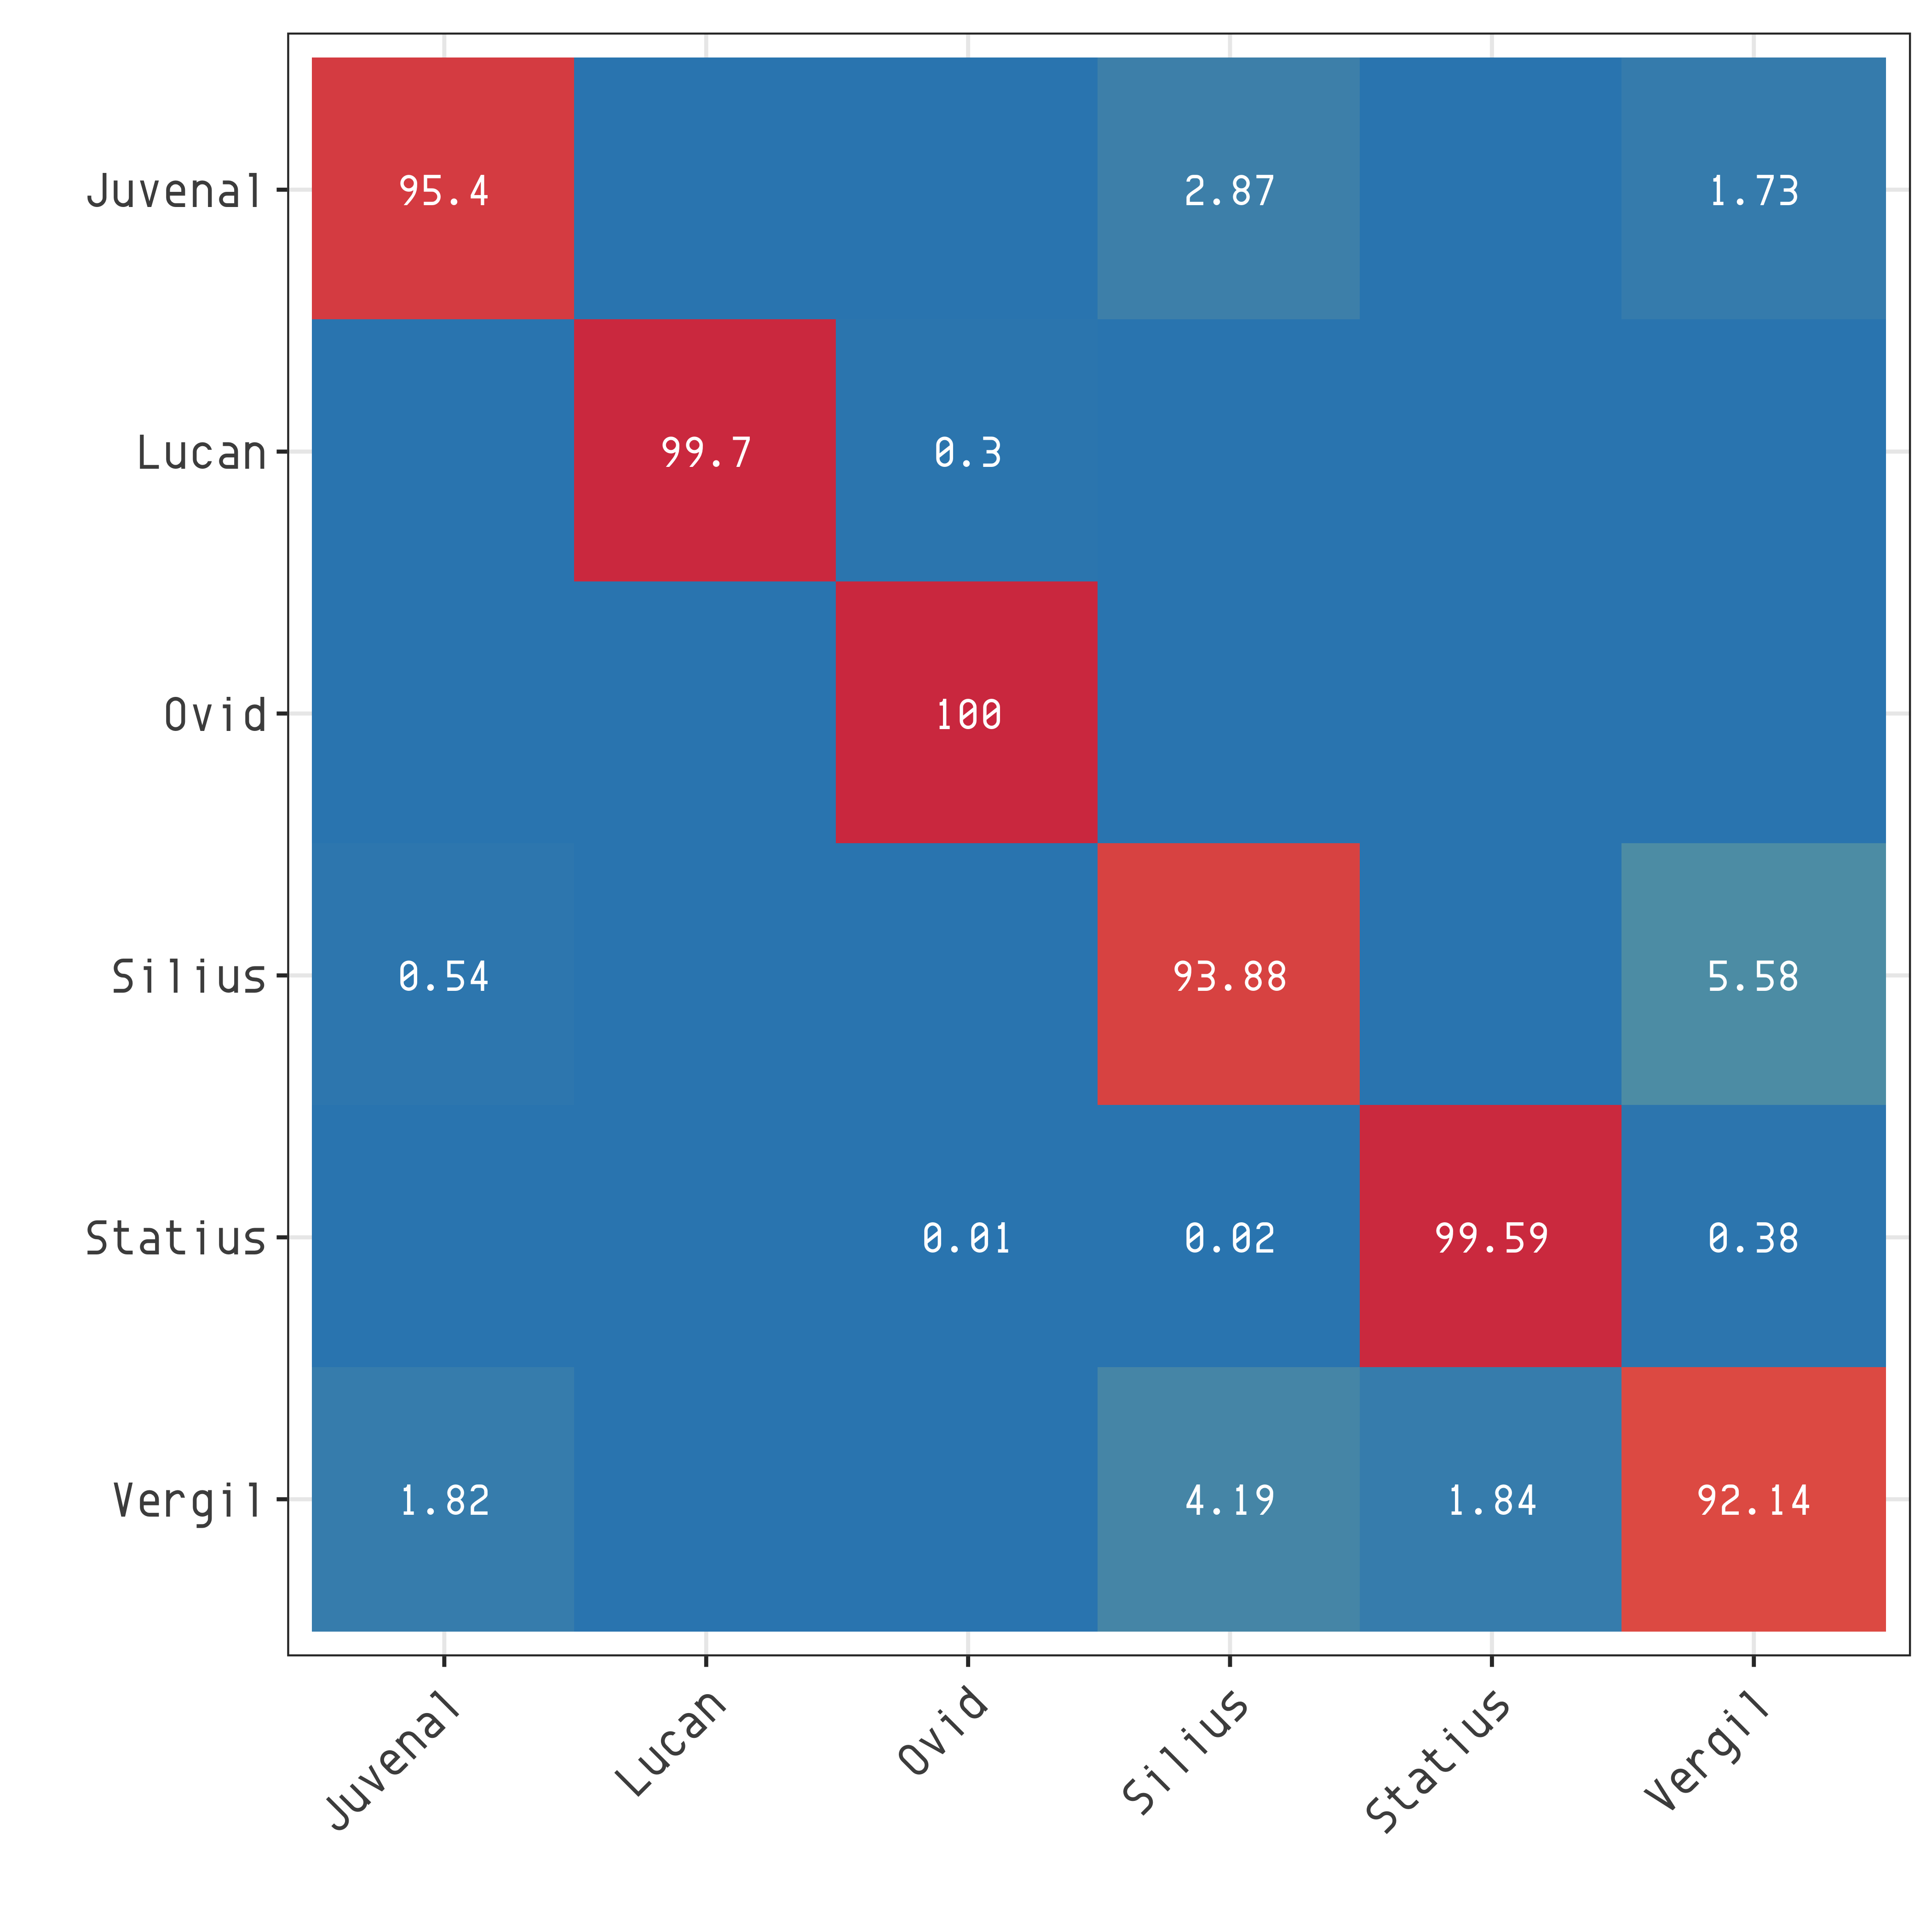

In [88]:
%%R -i cmdf -h 7 -w 7 -u in -r 600

cmdf <- cmdf %>%
  mutate(x = factor(x, levels= unique(x)), # alphabetical order by default
         y = factor(y, levels = rev(unique(y)))) # force reverse alphabetical order
    
ggplot(cmdf, aes(x=x, y=y, fill=val)) +
# slightly overlap the tiles to avoid a visible border line
geom_tile(width=1.01, height=1.01) +
scale_fill_distiller(palette="Spectral", direction=-1) +
guides(fill=F) + # removing legend for `fill`
theme_bw() +
# force it to be square
coord_equal() +
# supress output for 0
geom_text(
    aes(label=ifelse(round(cmdf$val,digits=2)==0, "", round(val,digits=2))),
    color="white",
    size=4,
    family="Envy Code R") + 
theme(text = element_text(size=16, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.95)) +
labs(x="", y="") +
theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [28]:
# Figure 5: Effectiveness of Different Feature Subsets
# (multiclass, randomised 81-line chunks)

In [29]:
f = [
    ('Feet Only',['1SP', '2SP', '3SP', '4SP']),
    ('Feet + Conflict', ['1SP', '2SP', '3SP', '4SP','1CF', '2CF', '3CF', '4CF']),
    ('Pauses', ['1DI', '2DI', '3DI','4DI', '1SC', '2SC', '3SC', '4SC', '1WC', '2WC', '3WC', '4WC']),
    ('Pauses + Conflict', ['1CF', '2CF', '3CF', '4CF', '1DI', '2DI', '3DI','4DI', '1SC', '2SC', '3SC', '4SC', '1WC', '2WC', '3WC', '4WC']),
    ('Top 8', ['ELC','1SP','4SP','3WC','3DI','4SC','1WC','3CF']),
    ('All Features', la.ALL_FEATURES),
]
feat_subsets = test_clf_by_feats(CLASSIFIERS, vecs_bya_na, f, size=81, samps=100)

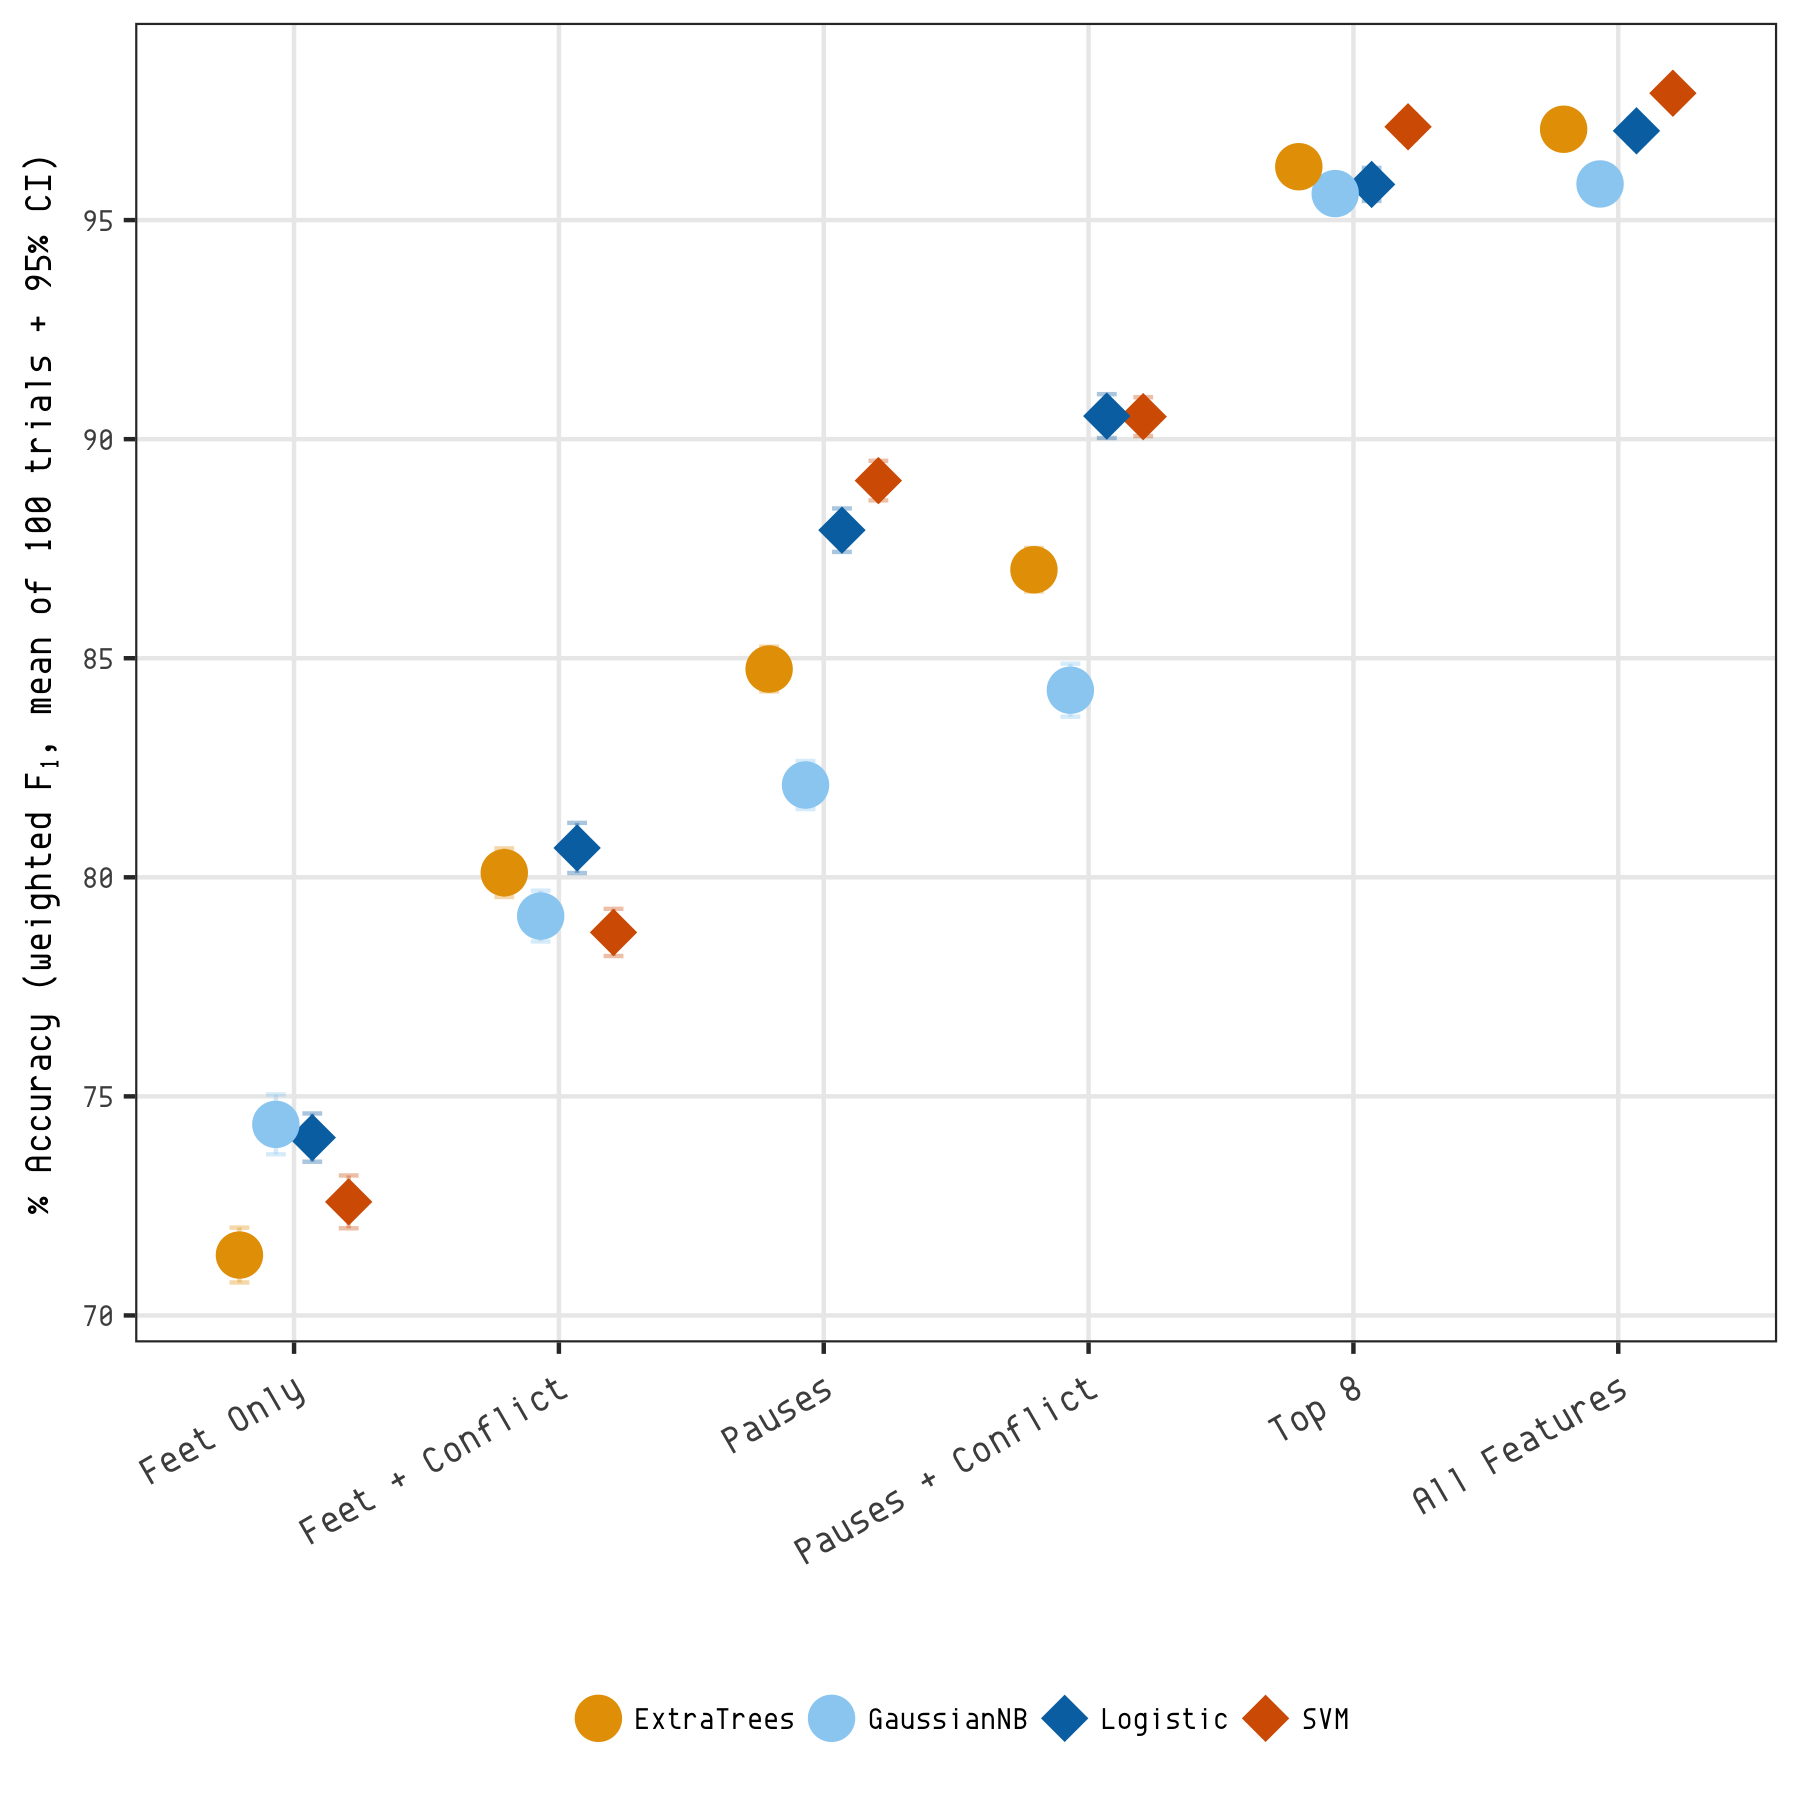

In [79]:
%%R -i feat_subsets -h 6 -w 6 -u in -r 300

# To _actually_ repro this might involve some fiddling around, and
# installing some fonts and such.

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

# best feature sets to the right
ggplot(data=feat_subsets, aes(x=fct_reorder(Features, Score), y=Score*100)) +
scale_shape_manual(values=c(16,16,18,18)) +
geom_errorbar(
    aes(ymin=Score*100-CI*100, ymax=Score*100+CI*100, color=Classifier), 
    width=0.3, alpha=0.35, position=position_dodge(width = 0.55), show.legend=FALSE) +
scale_y_continuous(breaks = seq(round(min(feat_subsets$Score*100),digits=-1), 100, by = 5)) +
geom_point(aes(shape=Classifier, color=Classifier), size=5, alpha=1, position=position_dodge(width = 0.55)) +
labs(x="",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(legend.position="bottom") +
theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust=0.95, size=9)) +
scale_colour_manual(values=cbbPaletteDark[c(2:5)])

In [31]:
# Table 3: Ranked Feature Importances, as determined by ExtraTrees
# and SVM (see Table 1 for abbreviation details)

In [32]:
rng = np.random.RandomState(seed=42)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=rng)
et = ExtraTreesClassifier(n_estimators=500,min_samples_split=2)
svc = SVC(gamma='scale', kernel='linear', C=128)


X = authc81r[la.ALL_FEATURES]
y = authc81r.Author

cv_results_et = cross_validate(et, X, y, cv=sss, n_jobs=1, return_estimator=True)
feat_imp_et = [x.feature_importances_ for x in cv_results_et['estimator']]
# ET feature importances sum to 1, but we'll show them as percentages
# because imho that is slightly easier for people to read
aa=sorted(list(zip(np.mean(feat_imp_et, axis=0)*100, la.ALL_FEATURES)), reverse=True)

cv_results_svc = cross_validate(svc, X, y, cv=sss, n_jobs=1, return_estimator=True)
# SVM results are positive/negative distances from the separating hyperplane.
# I'll take the absolute values and then rescale them to 100 (to match the ET scores)
feat_imp_svc = np.mean([[abs(y) for y in x.coef_[0]] for x in cv_results_svc['estimator']], axis=0)
norm_svc_results = feat_imp_svc / feat_imp_svc.sum()*100
bb = sorted(list(zip(norm_svc_results, la.ALL_FEATURES)), reverse=True)

In [33]:
d1 = dict([(x[1],x[0]) for x in aa])
d2 = dict([(x[1],x[0]) for x in bb])
d3 = dict(pd.DataFrame([d1,d2]).mean().sort_values(ascending=False))
cc = sorted({v:k for k,v in d3.items()}.items(), reverse=True)

In [90]:
z = list(zip(aa,bb,cc))
for a,b,c in z:
    print("%s  %5.2f       %s  %5.2f       %s  %5.2f" % (a[1], a[0], b[1], b[0], c[1], c[0]))

ELC  15.95       ELC  17.69       ELC  16.82
1SP  12.77       4SP  10.42       1SP   9.15
4SP   7.52       3WC   9.08       4SP   8.97
1WC   7.29       3DI   8.15       3WC   7.53
3WC   5.98       4SC   8.11       3DI   6.54
3DI   4.94       3CF   5.55       4SC   5.54
1CF   4.44       1SP   5.53       3CF   4.81
3SC   4.40       2DI   5.39       1WC   4.78
1DI   4.07       4CF   4.62       4CF   3.87
3CF   4.06       2WC   4.26       2DI   3.81
3SP   3.63       1DI   2.85       1DI   3.46
2CF   3.47       3SC   2.44       3SC   3.42
4CF   3.13       4DI   2.38       2WC   3.41
1SC   3.02       2CF   2.32       1CF   3.24
4SC   2.96       1WC   2.26       2CF   2.89
2WC   2.55       1CF   2.03       3SP   2.78
2DI   2.22       3SP   1.92       1SC   2.35
2SP   1.92       1SC   1.67       4DI   2.15
4WC   1.91       2SC   1.54       2SC   1.69
4DI   1.91       2SP   1.19       2SP   1.56
2SC   1.84       4WC   0.60       4WC   1.25


In [35]:
# Table 4: Some strongly correlated features in Latin hexameter poetry

In [36]:
corrmat = authc81r.corr()

a,b = np.where(np.logical_and(abs(corrmat)>0.6,abs(corrmat)<1.0)) # two arrays of indices
x = [(corrmat.columns[i],corrmat.columns[j]) for i,j in zip(a,b)] # pairwise (feat_i, feat_j) indices
correlated = [(corrmat[i][j], (i,j)) for i,j in x] # tuple (feat_i, feat_j), value
# dict using the score as the key to remove the duplicates
# since corr(a,b)==corr(b,a). Pretty hacky, tbh, but works
cd = dict(correlated)
for a, (b, c) in cd.items():
    print("%s %s        %6.3f" % (b,c,a))

4SP 1SP         0.607
1CF 1SP         0.776
1DI 1SP        -0.704
1WC 1SP        -0.815
3WC 3SP        -0.624
1DI 1CF        -0.701
1WC 1CF        -0.717
2WC 2CF        -0.744
3SC 3CF         0.857
3WC 3CF        -0.847
4SC 4CF         0.810
3WC 3SC        -0.807


In [37]:
# Table 5: A metrical comparison of the two most significant outliers.

In [38]:
# The code that emits the LaTeX for these tables is pretty ugly
# so this is a text version that's built into MQDQParser

# Again, this puts the cart before the horse a little because
# we need to calculate Fig. 6 in order to discover that the
# other outlier starts at 5652

In [39]:
puni_vecs = vecs_bywork.query('Work == "Punica"')
puni_vecs_shuf = puni_vecs.sample(frac=1, random_state=42)
addit_vecs = vecs_byauth.query('Author == "PsSilius"')
PUNI_DIST = maha._create_sampled_dist(puni_vecs_shuf, 81, 10000, seed=42)

In [40]:
maha.lazy_compare(addit_vecs, puni_vecs, rd=PUNI_DIST)

------------------------------
M-dist 57.85,  p-value: 0.0000
Feat 	 Score 	 Samp% 	 Dist%
------------------------------
2WC    19.37     0.00    11.48
1WC    14.55    23.46     9.52
4DI     7.37    35.80    50.81
1CF     6.14    28.40    42.48
1DI     4.73    22.22    29.44
4SC     2.87    66.67    60.16
3SC     2.49    79.01    81.80
2DI     1.75     4.94     7.53
3CF     1.74    87.65    84.30
3WC     1.69     9.88    12.22
4SP     0.75    76.54    72.64
1SC     0.73    34.57    30.68
3DI     0.30    12.35    10.52
4WC     0.30     6.17     4.89
3SP     0.30    59.26    61.33
2SP    -0.17    62.96    56.36
ELC    -0.41    51.85    44.17
1SP    -0.55    43.21    50.61
2SC    -1.41    72.84    62.86
4CF    -1.43    64.20    60.74
2CF    -3.27    82.72    78.42
------------------------------


In [41]:
# The negative values here show how the algorithm compensates
# for correlation. In Table 4 we see 4SC and 4CF are strongly
# correlated (r=0.810), so although the 4CF value is also low
# some distance is actually subtracted from the final score.

maha.lazy_compare(puni_vecs[5652:5652+81], puni_vecs, rd=PUNI_DIST)

------------------------------
M-dist 61.60,  p-value: 0.0000
Feat 	 Score 	 Samp% 	 Dist%
------------------------------
4SC    40.07    34.57    60.16
3SP     7.81    76.54    61.33
3DI     4.40    18.52    10.52
4DI     4.28    41.98    50.81
4WC     4.07    11.11     4.89
1DI     2.94    23.46    29.44
4SP     2.91    79.01    72.64
1SP     2.00    58.02    50.61
1SC     1.87    23.46    30.68
2WC     1.67     9.88    11.48
2CF     1.15    76.54    78.42
2DI     0.89     3.70     7.53
1WC     0.81    12.35     9.52
1CF     0.60    49.38    42.48
3CF     0.31    88.89    84.30
3SC     0.24    87.65    81.80
2SP     0.12    54.32    56.36
2SC    -0.40    64.20    62.86
ELC    -0.62    46.91    44.17
3WC    -1.34     9.88    12.22
4CF   -12.17    45.68    60.74
------------------------------


In [42]:
# Figure 6: The M^2 distance through the Punica, taking a rolling
# window of 81-line chunks. The distance of the Additamentum is
# shown as a horizontal dotted line. Chunks that overlap the 
# Additamentum are drawn crossed.

In [43]:
CHUNKSZ=81
DISTSZ=10000
STEP=9

res_rdist = []
for cut in np.arange(0,len(puni_vecs)-CHUNKSZ,STEP):
    samp = puni_vecs[cut:cut+CHUNKSZ]
    if len(samp) != CHUNKSZ:
        raise RuntimeError("incorrect chunk size!")
    m, _, _ = maha.chunk_explain(samp, puni_vecs, rd=PUNI_DIST)
    res_rdist.append(m)

In [44]:
sp.stats.describe(res_rdist)

DescribeResult(nobs=1347, minmax=(8.782356137897146, 69.76684970680559), mean=25.549798205797874, variance=66.8684015882463, skewness=0.7650314962279674, kurtosis=1.0766348627028695)

In [47]:
# Tidy up the data
silius_m_var = pd.DataFrame(zip(np.arange(0,len(puni_vecs)-CHUNKSZ,STEP), res_rdist))
silius_m_var.columns=['L', 'M']

addit_m_dist = maha.chunk_explain(addit_vecs, puni_vecs, n=DISTSZ, seed=42, rd=PUNI_DIST)[0]

In [48]:
# The only huge outlier that doesn't overlap the Additamentum (5230:5311)
# starts at 5652. There are also three more in that neighbourhood which
# have high scores for the same reason.

weird_chunks = silius_m_var[silius_m_var['M']>addit_m_dist]
weird_chunks = weird_chunks.reset_index()
weird_chunks['L'] = weird_chunks['L'].astype('int64')
weird_chunks

index     L          M
0    582  5238  69.766850
1    583  5247  62.193037
2    628  5652  61.598935

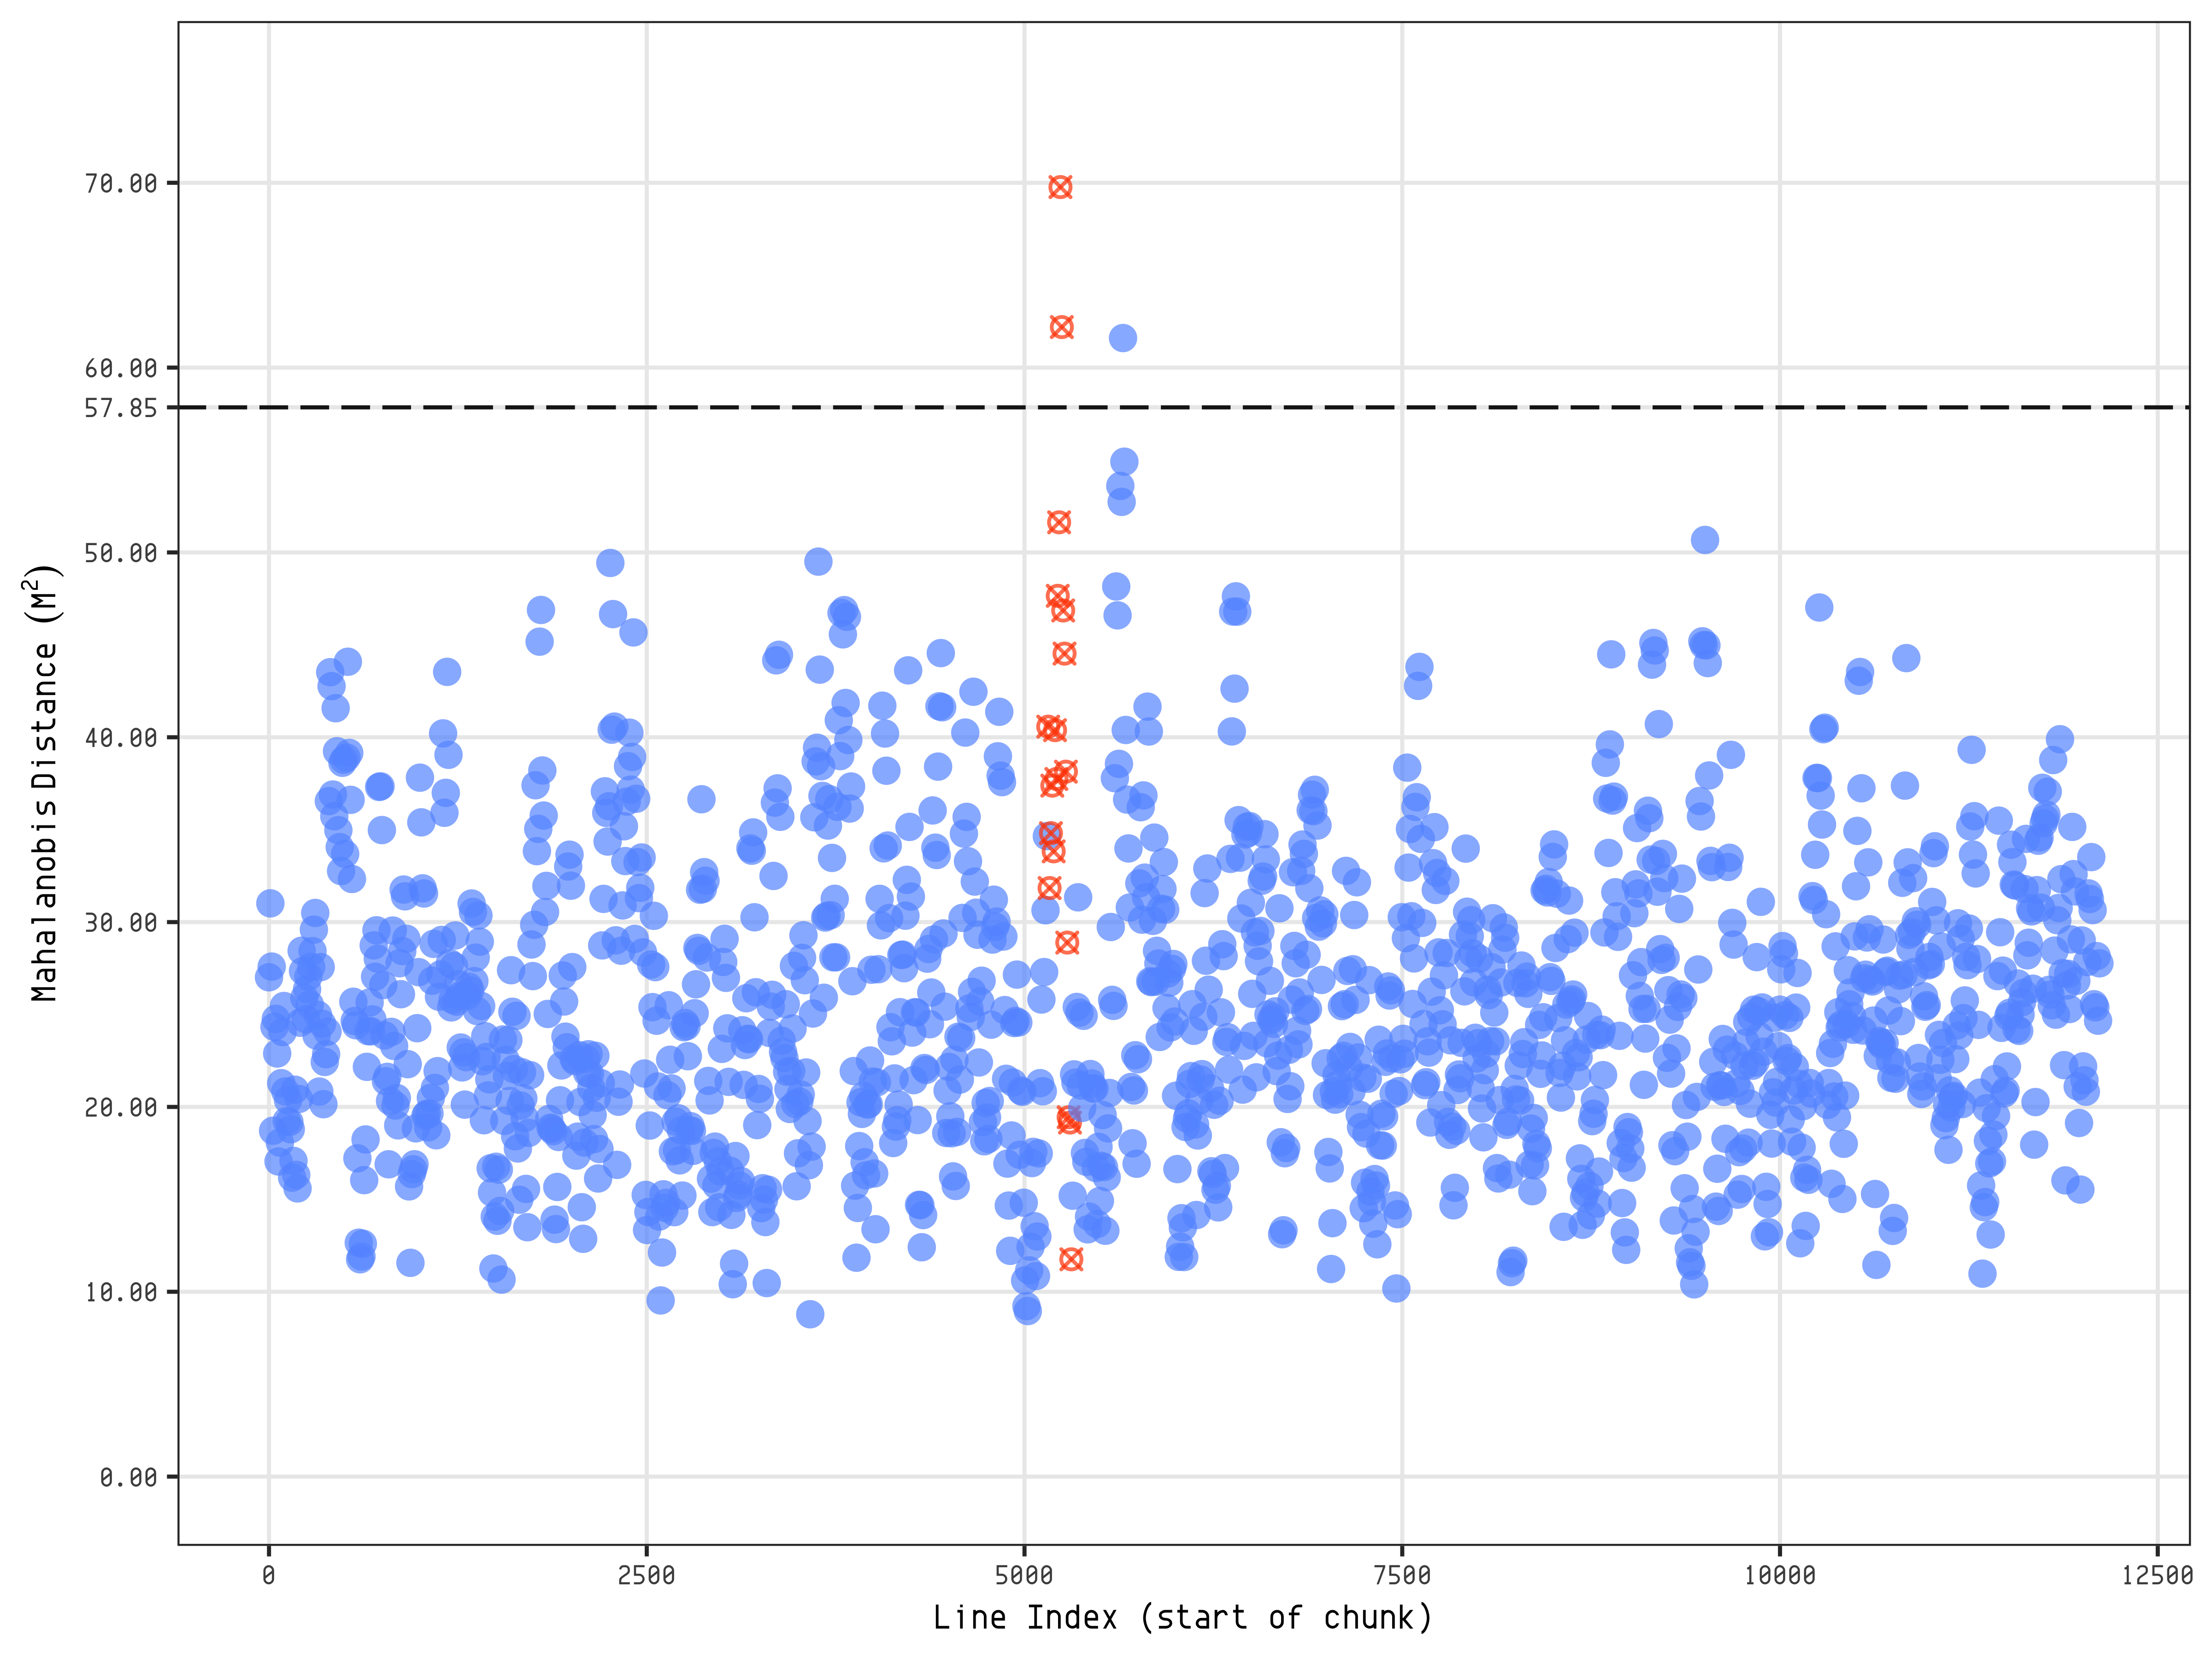

In [49]:
%%R -i silius_m_var,addit_m_dist -h 6 -w 8 -u in -r 600

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))
f <- function(l) {return(l<5230-81 | l>5230+81)}

ggplot(data=silius_m_var,aes(x=L, y=M, shape=f(L), colour=f(L), size=f(L))) +
geom_point(alpha=0.7, stroke=0.7) +
scale_shape_manual(values=c(13,16)) +
scale_color_manual(values=c("#FF4900", "#6699ff")) +
scale_size_manual(values=c(2,3)) +
geom_hline(yintercept=addit_m_dist, linetype=5, color=grey(0.1)) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.position='none') +
theme(plot.title = element_text(margin = margin(b = 50))) +
scale_y_continuous(limits=c(0,75), breaks=c(0,10,20,30,40,50,round(addit_m_dist,2),60,70)) +
labs(x="Line Index (start of chunk)",y=expression(Mahalanobis~Distance~~(M^2)))